In [1]:
# Student Engagement and Failure Prediction - EDA Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)   # 显示所有列
pd.set_option('display.width', None)         # 根据终端宽度自动换行
pd.set_option('display.max_colwidth', None)  # 不截断长文本

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Data Loading and Basic Information

# Load the dataset
df = pd.read_csv('train_weekly.csv')

print("=== DATASET OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print(f"Total samples: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]:,}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(df.head())


=== DATASET OVERVIEW ===
Dataset shape: (562912, 69)
Total samples: 562,912
Total features: 69
Memory usage: 570.03 MB
   id_student code_module code_presentation  week  cum_click_dataplus  \
0        6516         AAA             2014J    -4                 0.0   
1      639514         DDD             2014J    -4                 0.0   
2     2008795         DDD             2014J    -4                 0.0   
3      391249         AAA             2014J    -4                 0.0   
4      390890         AAA             2014J    -4                 0.0   

   cum_click_dualpane  cum_click_externalquiz  cum_click_folder  \
0                 0.0                     0.0               0.0   
1                 0.0                     0.0               0.0   
2                 0.0                     0.0               0.0   
3                 0.0                     0.0               0.0   
4                 0.0                     0.0               0.0   

   cum_click_forumng  cum_click_glossar


=== DATA COMPLETENESS ===
✓ No missing values found in the dataset!


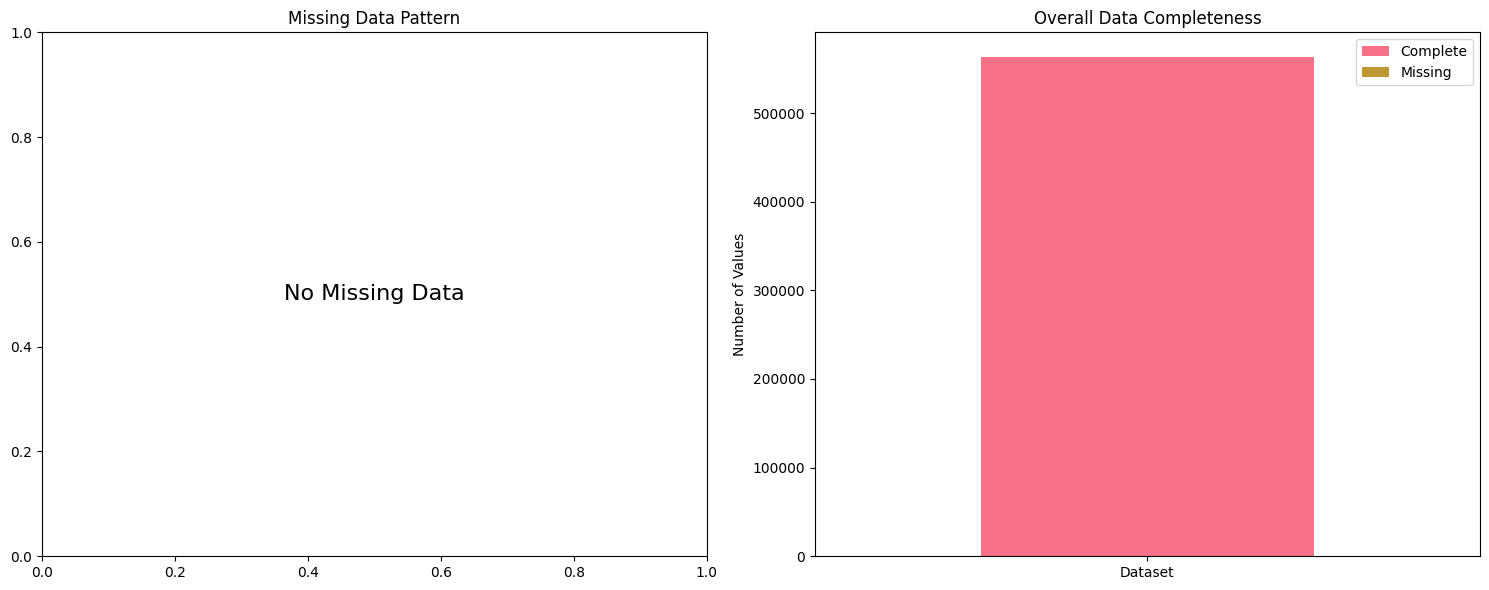

In [2]:
## 2. Data Completeness Analysis

print("\n=== DATA COMPLETENESS ===")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

completeness_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Percentage', ascending=False)

# Display columns with missing values
missing_cols = completeness_df[completeness_df['Missing_Count'] > 0]
if len(missing_cols) > 0:
    print("Columns with missing values:")
    print(missing_cols)
else:
    print("✓ No missing values found in the dataset!")

# Visualize missing data pattern
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Missing data heatmap (top 20 columns if many)
if len(missing_cols) > 0:
    top_missing = missing_cols.head(20)
    sns.heatmap(df[top_missing.index].isnull(), 
                yticklabels=False, cbar=True, ax=axes[0])
    axes[0].set_title('Missing Data Pattern')
else:
    axes[0].text(0.5, 0.5, 'No Missing Data', ha='center', va='center', fontsize=16)
    axes[0].set_title('Missing Data Pattern')

# Data completeness bar chart
completeness_summary = pd.DataFrame({
    'Complete': [len(df) - missing_data.sum()],
    'Missing': [missing_data.sum()]
})
completeness_summary.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Overall Data Completeness')
axes[1].set_ylabel('Number of Values')
axes[1].set_xticklabels(['Dataset'], rotation=0)

plt.tight_layout()
plt.show()


=== TARGET VARIABLE ANALYSIS ===
Target distribution (target_fail):
  PASS (0): 524,688 samples (93.21%)
  FAIL (1): 38,224 samples (6.79%)

Class balance ratio: 0.073
⚠️  IMBALANCED DATASET detected! Consider resampling techniques.


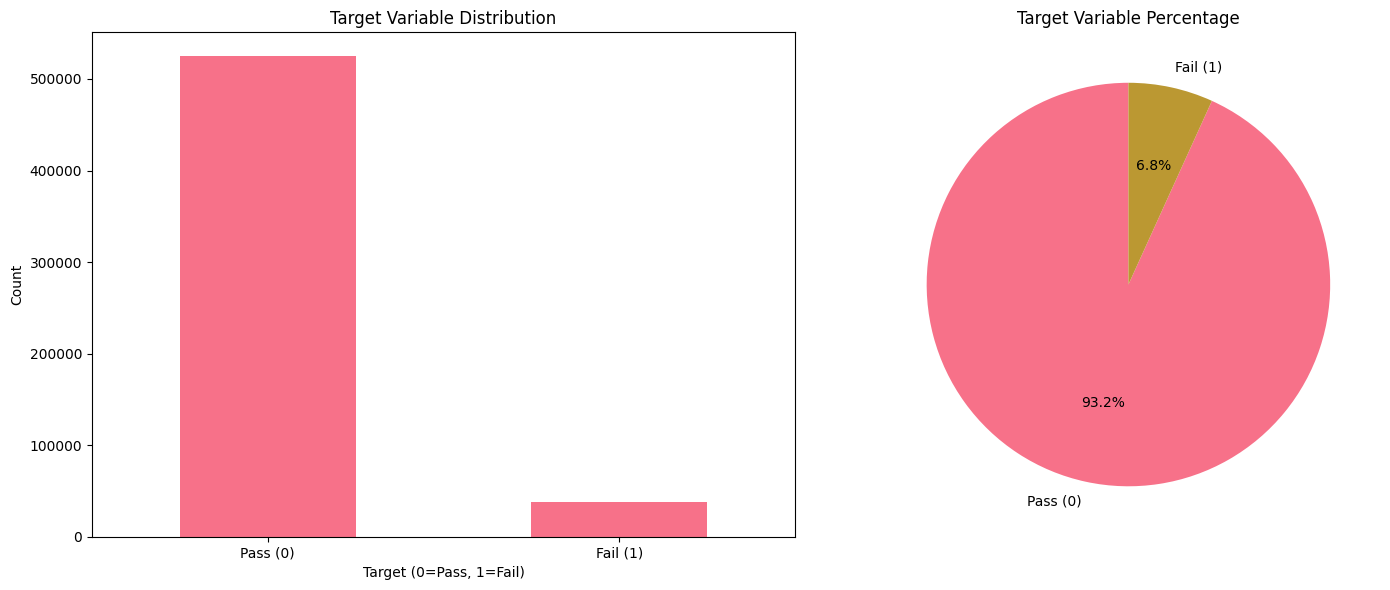

In [3]:
## 3. Target Variable Analysis

print("\n=== TARGET VARIABLE ANALYSIS ===")
target_dist = df['target_fail'].value_counts()
target_pct = df['target_fail'].value_counts(normalize=True) * 100

print("Target distribution (target_fail):")
for val, count in target_dist.items():
    pct = target_pct[val]
    status = "PASS" if val == 0 else "FAIL"
    print(f"  {status} ({val}): {count:,} samples ({pct:.2f}%)")

# Check for class imbalance
imbalance_ratio = target_dist.min() / target_dist.max()
print(f"\nClass balance ratio: {imbalance_ratio:.3f}")
if imbalance_ratio < 0.3:
    print("⚠️  IMBALANCED DATASET detected! Consider resampling techniques.")
else:
    print("✓ Dataset is reasonably balanced.")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
target_dist.plot(kind='bar', ax=axes[0])
axes[0].set_title('Target Variable Distribution')
axes[0].set_xlabel('Target (0=Pass, 1=Fail)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Pass (0)', 'Fail (1)'], rotation=0)

# Pie chart
axes[1].pie(target_dist.values, labels=['Pass (0)', 'Fail (1)'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Target Variable Percentage')

plt.tight_layout()
plt.show()


=== FEATURE CATEGORIES ===
Click-related features: 42
Demographic features: 5
Numeric features: 59

=== KEY NUMERIC FEATURES DISTRIBUTION ===


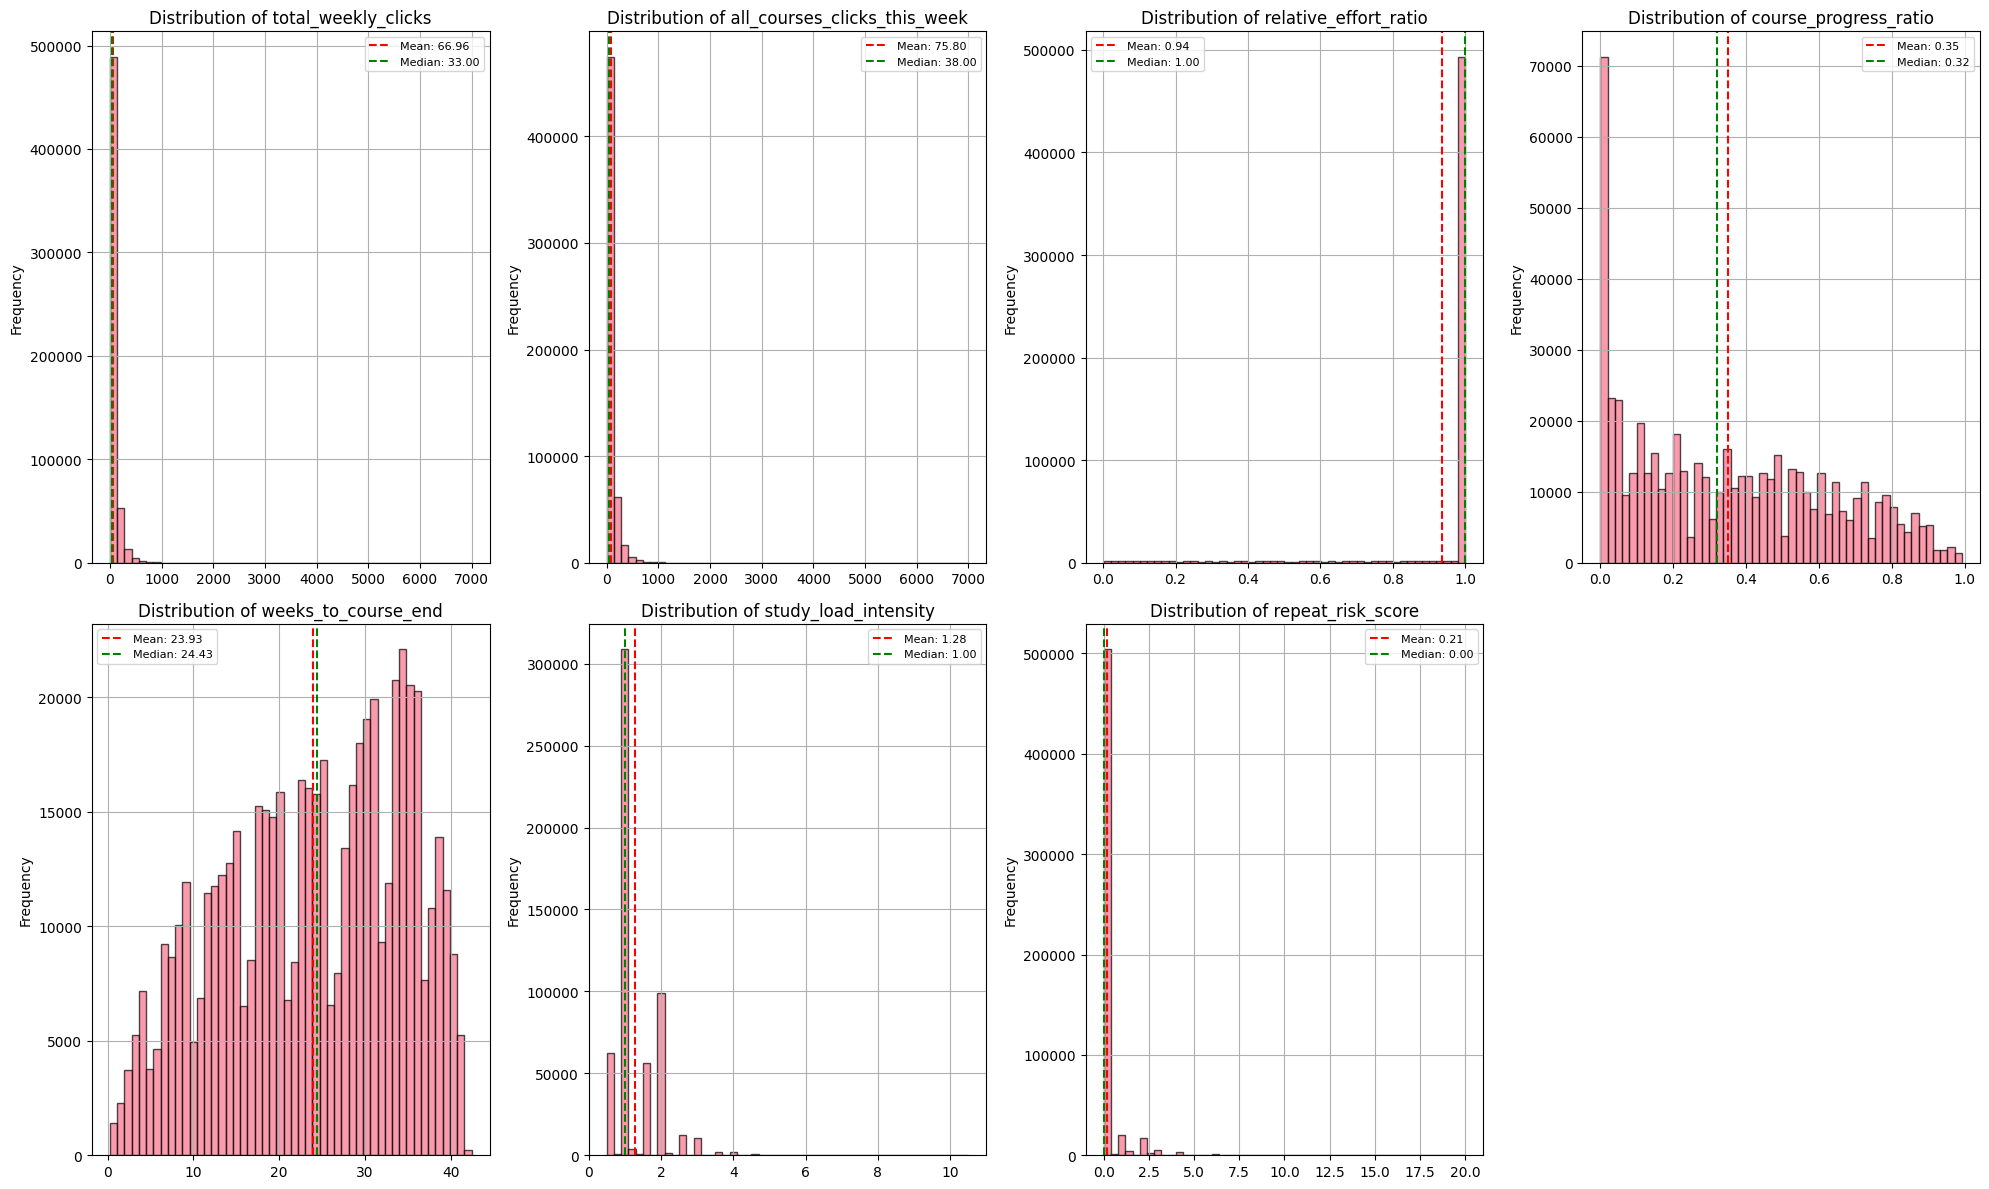


Statistical Summary of Key Numeric Features:
       total_weekly_clicks  all_courses_clicks_this_week  \
count           562912.000                    562912.000   
mean                66.961                        75.795   
std                 99.629                       110.467   
min                  1.000                         1.000   
25%                 11.000                        13.000   
50%                 33.000                        38.000   
75%                 84.000                        95.000   
max               6999.000                      6999.000   

       relative_effort_ratio  course_progress_ratio  weeks_to_course_end  \
count             562912.000             562912.000           562912.000   
mean                   0.936                  0.351               23.932   
std                    0.199                  0.276               10.416   
min                    0.001                  0.000                0.286   
25%                    1.000     

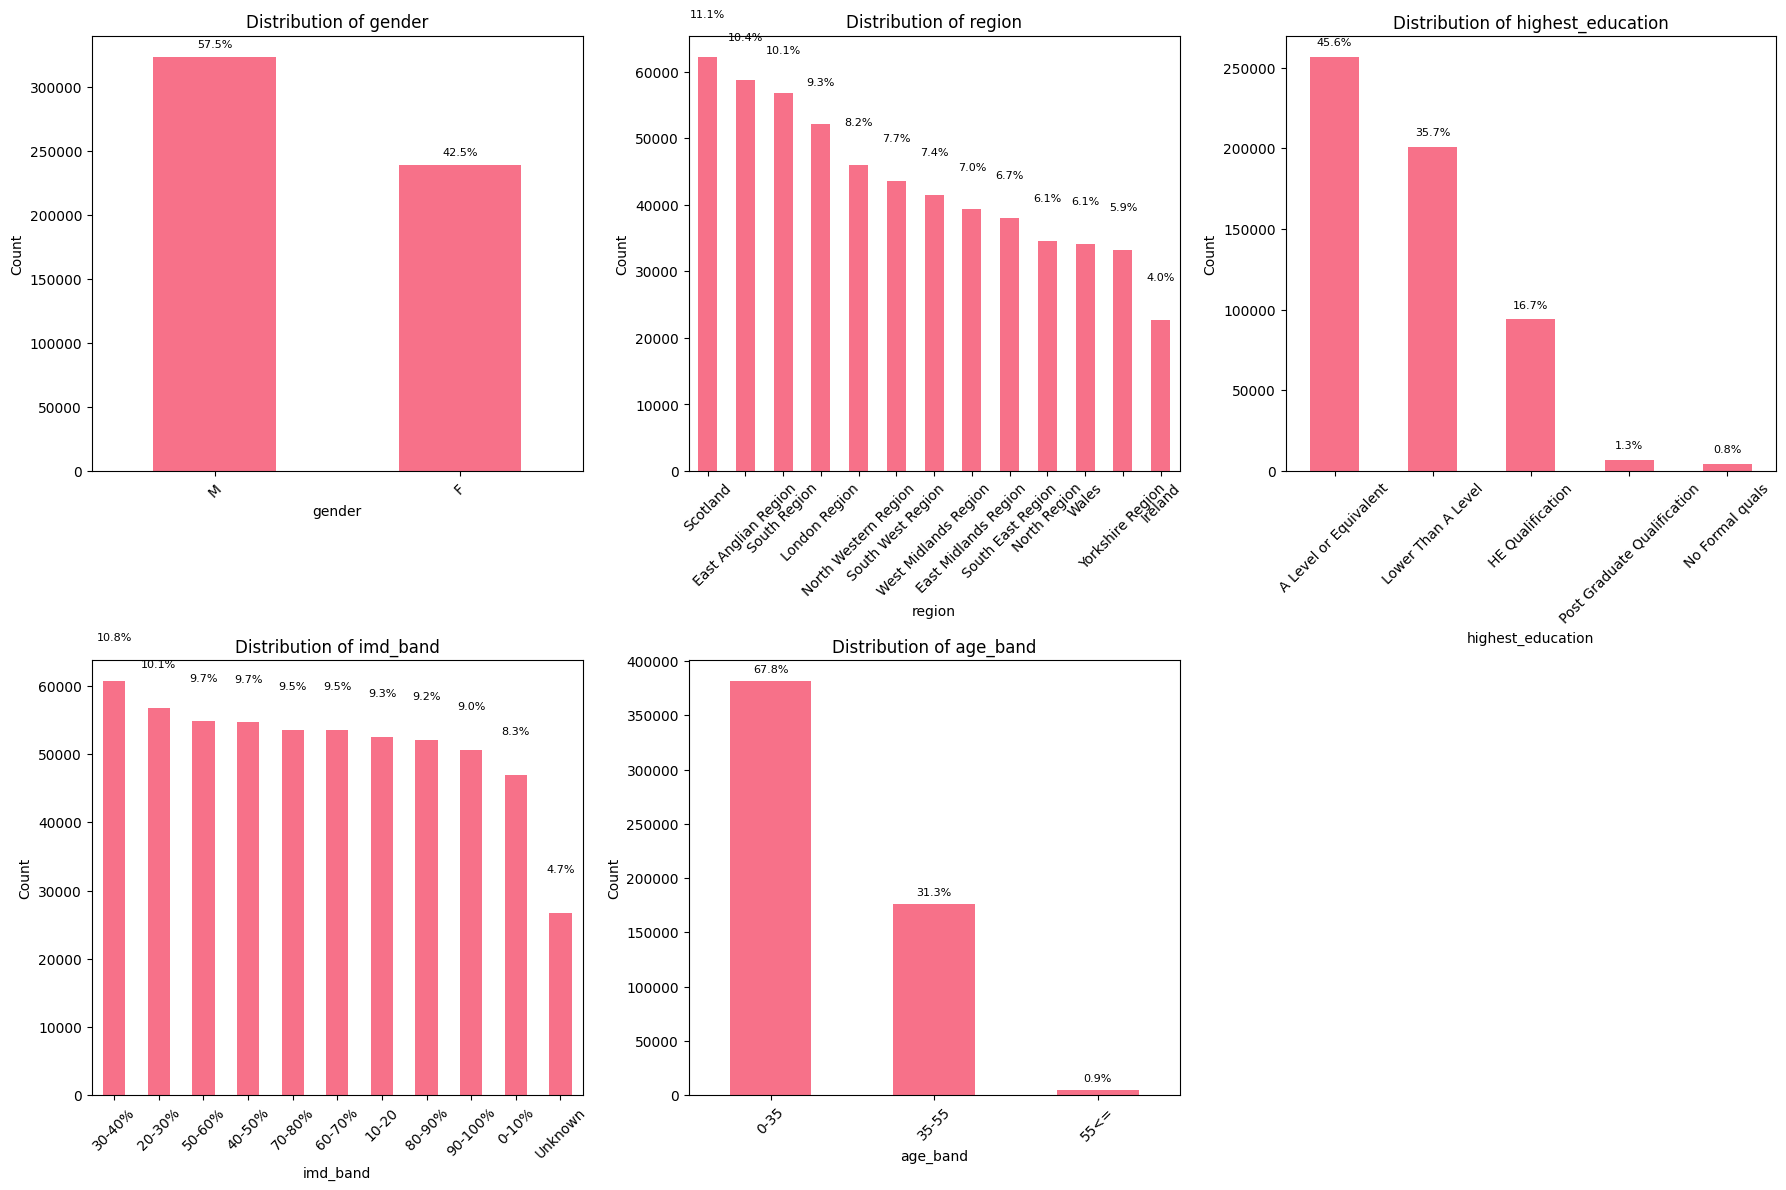

In [4]:
## 4. Feature Distribution Analysis

# Identify different types of features
click_columns = [col for col in df.columns if 'click' in col.lower()]
demographic_columns = ['gender', 'region', 'highest_education', 'imd_band', 'age_band']
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n=== FEATURE CATEGORIES ===")
print(f"Click-related features: {len(click_columns)}")
print(f"Demographic features: {len(demographic_columns)}")
print(f"Numeric features: {len(numeric_columns)}")

### 4.1 Key Numeric Features Distribution

key_numeric_features = [
    'total_weekly_clicks', 'all_courses_clicks_this_week', 
    'relative_effort_ratio', 'course_progress_ratio', 'weeks_to_course_end',
    'study_load_intensity', 'repeat_risk_score'
]

# Filter existing columns
key_numeric_features = [col for col in key_numeric_features if col in df.columns]

print(f"\n=== KEY NUMERIC FEATURES DISTRIBUTION ===")
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.ravel()

for i, feature in enumerate(key_numeric_features[:8]):
    if i < len(axes):
        # Histogram with KDE
        df[feature].hist(bins=50, ax=axes[i], alpha=0.7, edgecolor='black')
        axes[i].axvline(df[feature].mean(), color='red', linestyle='--', label=f'Mean: {df[feature].mean():.2f}')
        axes[i].axvline(df[feature].median(), color='green', linestyle='--', label=f'Median: {df[feature].median():.2f}')
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_ylabel('Frequency')
        axes[i].legend(fontsize=8)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Statistical summary
print("\nStatistical Summary of Key Numeric Features:")
print(df[key_numeric_features].describe().round(3))

### 4.2 Demographic Features Distribution

print(f"\n=== DEMOGRAPHIC FEATURES DISTRIBUTION ===")
existing_demo_cols = [col for col in demographic_columns if col in df.columns]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(existing_demo_cols):
    if i < len(axes):
        value_counts = df[feature].value_counts()
        
        # Bar plot
        value_counts.plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add percentage labels
        total = value_counts.sum()
        for j, (idx, val) in enumerate(value_counts.items()):
            pct = (val/total) * 100
            axes[i].text(j, val + total*0.01, f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

# Remove empty subplots
for j in range(len(existing_demo_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



=== TARGET vs ENGAGEMENT ANALYSIS ===


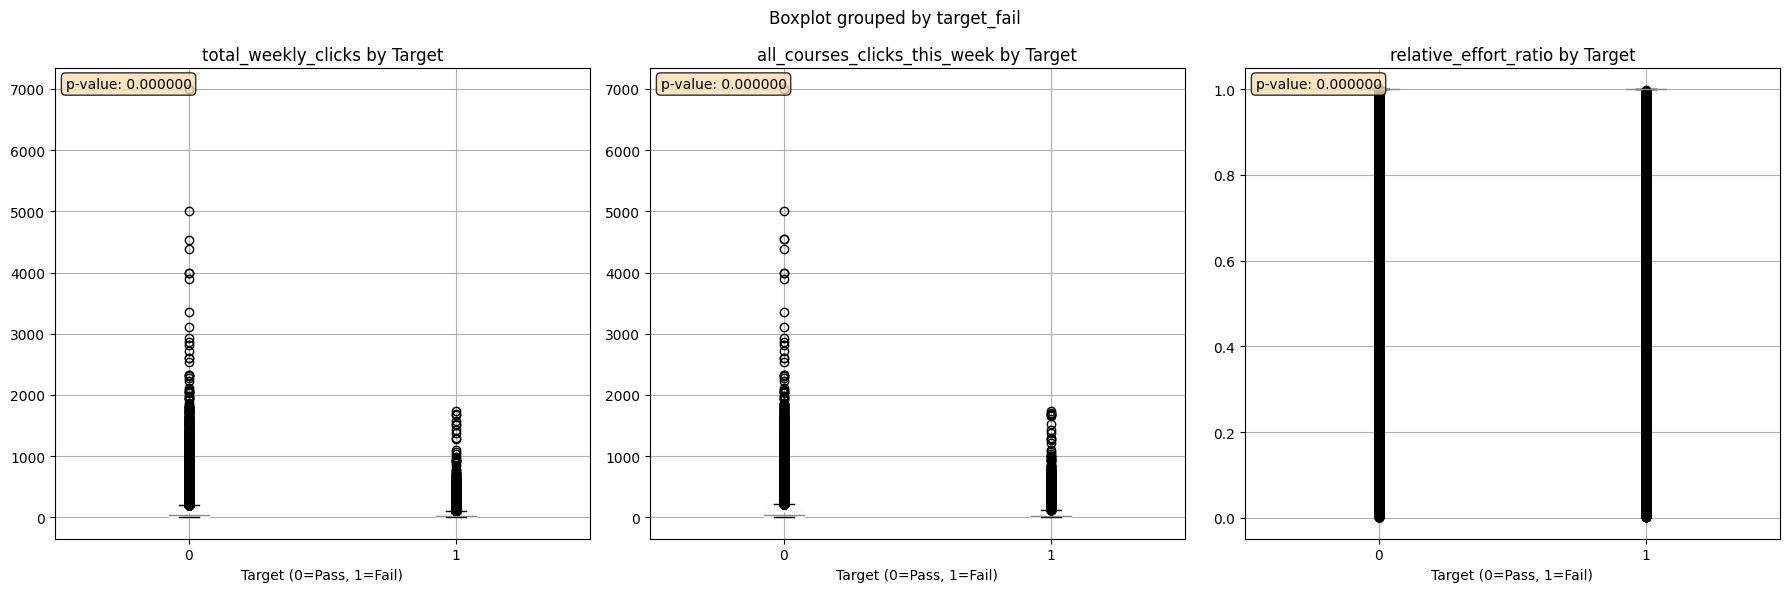


total_weekly_clicks by Target:
               mean  median      std
target_fail                         
0            69.182    35.0  101.424
1            36.474    16.0   63.057

all_courses_clicks_this_week by Target:
               mean  median      std
target_fail                         
0            77.907    40.0  112.144
1            46.809    21.0   78.597

relative_effort_ratio by Target:
              mean  median    std
target_fail                      
0            0.939     1.0  0.195
1            0.899     1.0  0.252

=== TARGET vs DEMOGRAPHICS ANALYSIS ===


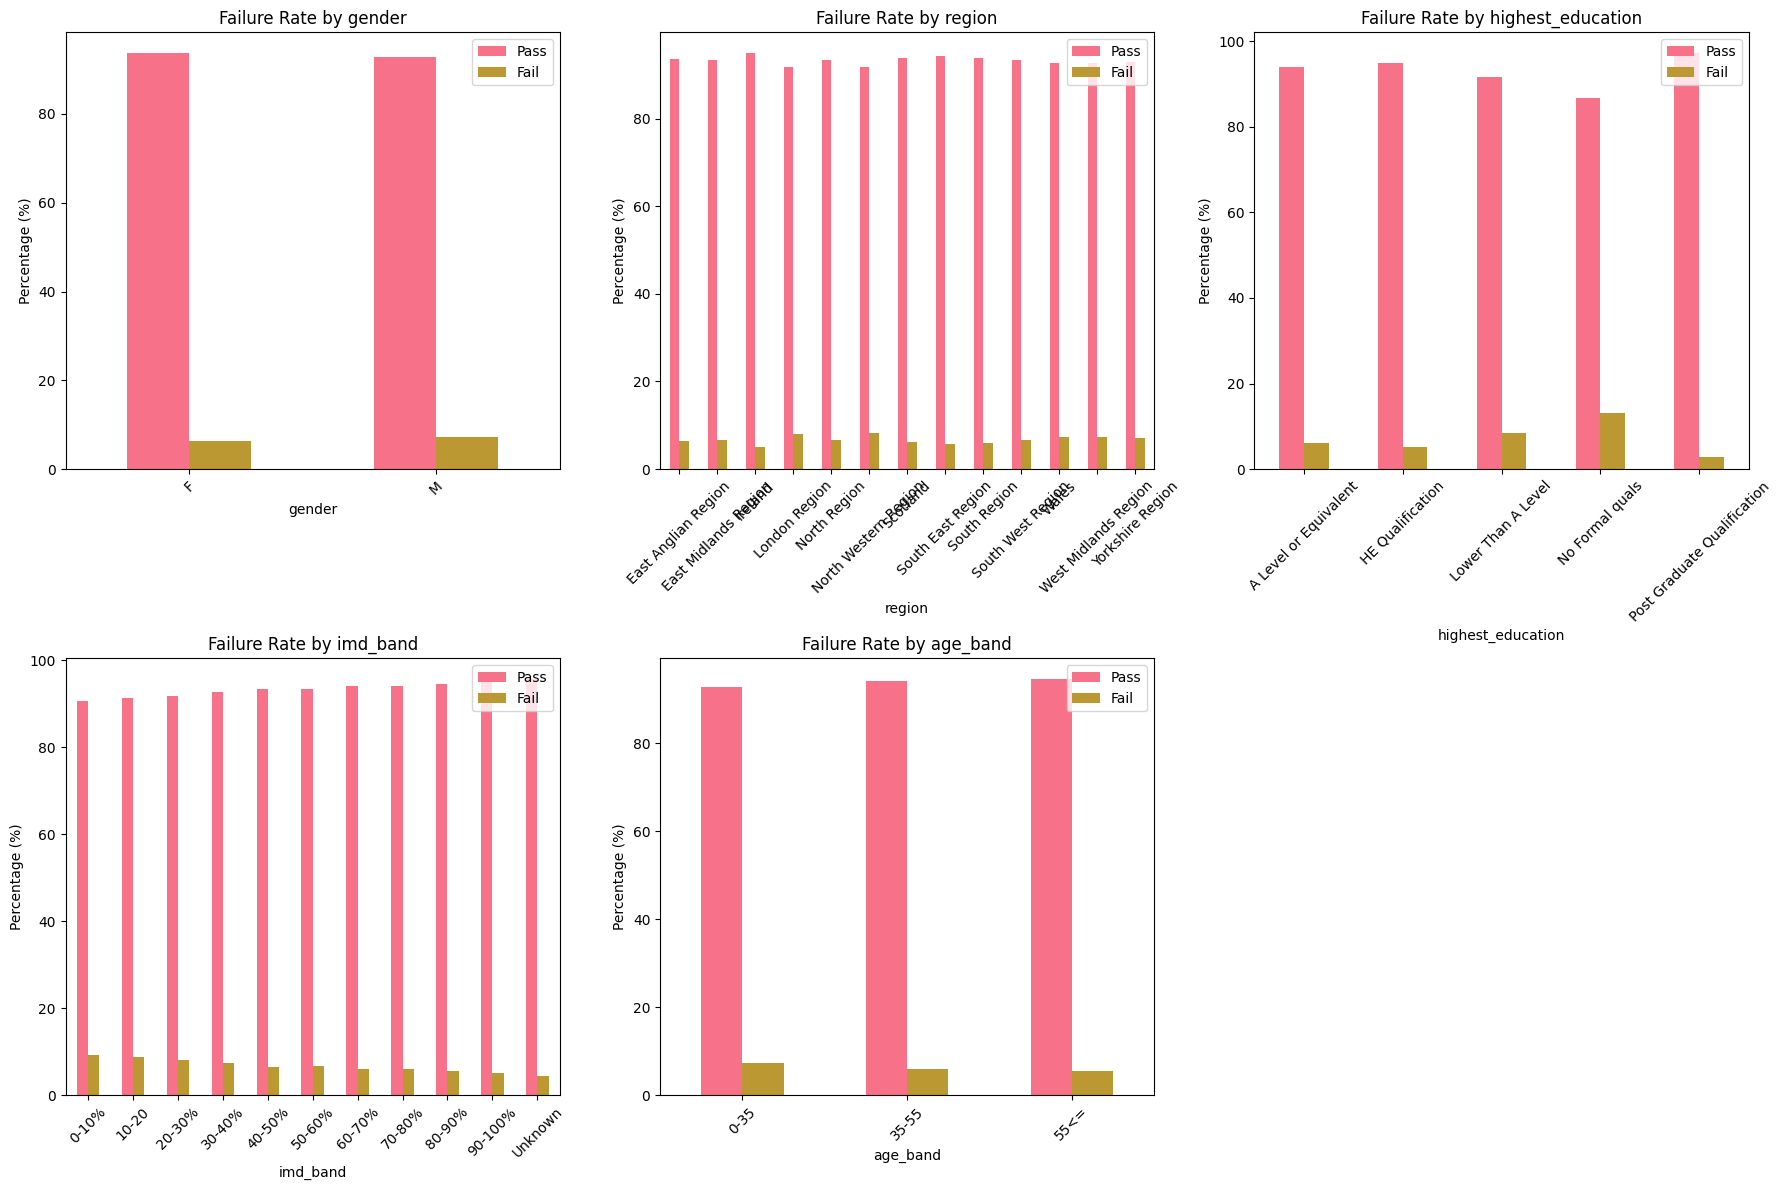


gender vs Target Failure:
Counts:
target_fail       0      1     All
gender                            
F            224072  15092  239164
M            300616  23132  323748
All          524688  38224  562912

Percentages:
target_fail      0     1
gender                  
F            93.69  6.31
M            92.85  7.15

region vs Target Failure:
Counts:
target_fail                0      1     All
region                                     
East Anglian Region    55035   3744   58779
East Midlands Region   36681   2635   39316
Ireland                21530   1145   22675
London Region          47859   4233   52092
North Region           32313   2276   34589
North Western Region   42198   3758   45956
Scotland               58341   3895   62236
South East Region      35780   2201   37981
South Region           53369   3446   56815
South West Region      40682   2923   43605
Wales                  31636   2522   34158
West Midlands Region   38470   3073   41543
Yorkshire Region       30

In [5]:
## 5. Target vs Features Relationship Analysis

### 5.1 Target vs Engagement (Click Activity)

print(f"\n=== TARGET vs ENGAGEMENT ANALYSIS ===")

# Focus on key engagement metrics
engagement_features = ['total_weekly_clicks', 'all_courses_clicks_this_week', 'relative_effort_ratio']
existing_engagement = [col for col in engagement_features if col in df.columns]

fig, axes = plt.subplots(1, len(existing_engagement), figsize=(6*len(existing_engagement), 6))
if len(existing_engagement) == 1:
    axes = [axes]

for i, feature in enumerate(existing_engagement):
    # Box plot showing distribution by target
    df.boxplot(column=feature, by='target_fail', ax=axes[i])
    axes[i].set_title(f'{feature} by Target')
    axes[i].set_xlabel('Target (0=Pass, 1=Fail)')
    
    # Add statistical test
    pass_group = df[df['target_fail'] == 0][feature]
    fail_group = df[df['target_fail'] == 1][feature]
    
    # Mann-Whitney U test (non-parametric)
    statistic, p_value = stats.mannwhitneyu(pass_group, fail_group, alternative='two-sided')
    axes[i].text(0.02, 0.98, f'p-value: {p_value:.6f}', transform=axes[i].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics by target
for feature in existing_engagement:
    print(f"\n{feature} by Target:")
    summary = df.groupby('target_fail')[feature].agg(['mean', 'median', 'std']).round(3)
    print(summary)

### 5.2 Target vs Demographics

print(f"\n=== TARGET vs DEMOGRAPHICS ANALYSIS ===")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(existing_demo_cols):
    if i < len(axes):
        # Cross-tabulation
        ct = pd.crosstab(df[feature], df['target_fail'], normalize='index') * 100
        
        ct.plot(kind='bar', ax=axes[i], stacked=False)
        axes[i].set_title(f'Failure Rate by {feature}')
        axes[i].set_ylabel('Percentage (%)')
        axes[i].legend(['Pass', 'Fail'])
        axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots
for j in range(len(existing_demo_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Print detailed cross-tabulations
for feature in existing_demo_cols:
    print(f"\n{feature} vs Target Failure:")
    ct = pd.crosstab(df[feature], df['target_fail'], margins=True)
    ct_pct = pd.crosstab(df[feature], df['target_fail'], normalize='index') * 100
    print("Counts:")
    print(ct)
    print("\nPercentages:")
    print(ct_pct.round(2))



=== TEMPORAL PATTERN ANALYSIS ===


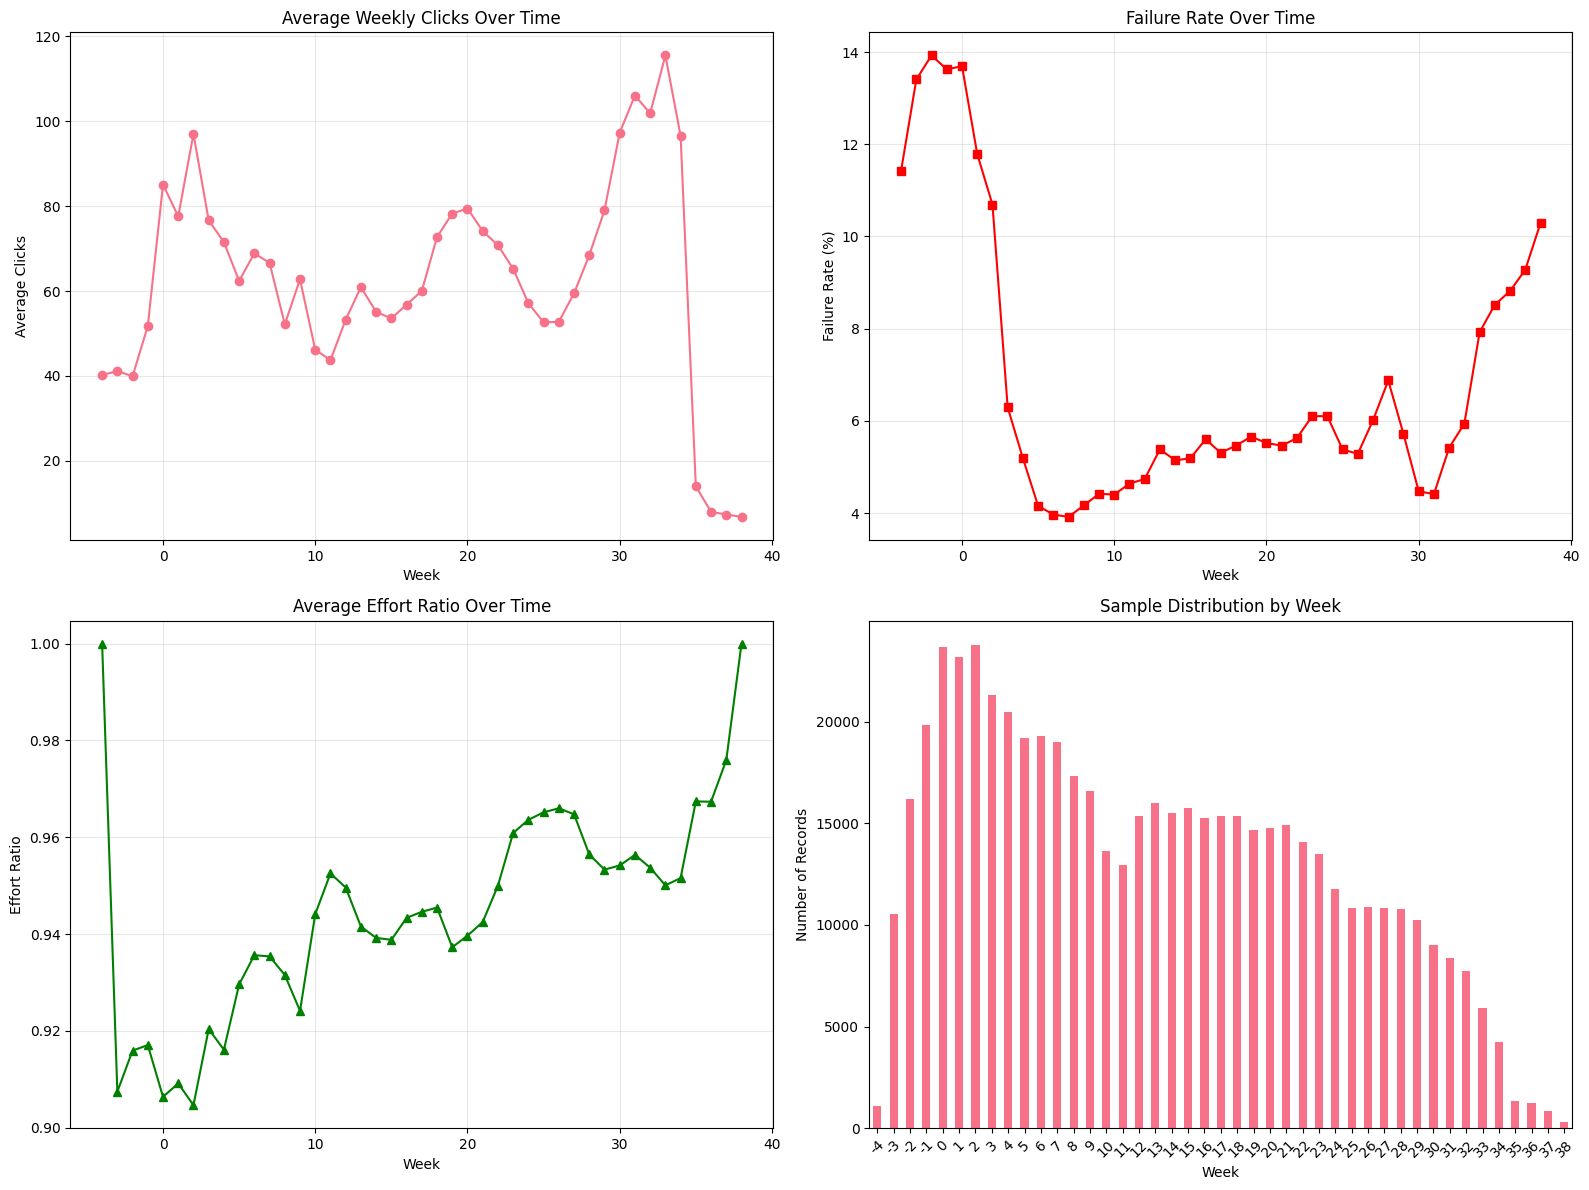

Weekly Statistics Summary:
     total_weekly_clicks          target_fail relative_effort_ratio
                    mean      std        mean                  mean
week                                                               
-4                40.240   62.542       0.114                 1.000
-3                41.151   62.096       0.134                 0.907
-2                39.936   63.182       0.139                 0.916
-1                51.756   79.581       0.136                 0.917
 0                85.091  114.852       0.137                 0.906
 1                77.592   98.393       0.118                 0.909
 2                97.000  110.175       0.107                 0.905
 3                76.676  100.979       0.063                 0.920
 4                71.507   91.607       0.052                 0.916
 5                62.412   86.290       0.042                 0.930
 6                68.891  103.546       0.040                 0.936
 7                66.

In [6]:
## 6. Temporal Pattern Analysis

### 6.1 Weekly Patterns

print(f"\n=== TEMPORAL PATTERN ANALYSIS ===")

# Week vs engagement
if 'week' in df.columns:
    weekly_stats = df.groupby('week').agg({
        'total_weekly_clicks': ['mean', 'std'],
        'target_fail': 'mean',
        'relative_effort_ratio': 'mean'
    }).round(3)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Weekly click trends
    weekly_clicks = df.groupby('week')['total_weekly_clicks'].mean()
    weekly_clicks.plot(kind='line', marker='o', ax=axes[0,0])
    axes[0,0].set_title('Average Weekly Clicks Over Time')
    axes[0,0].set_xlabel('Week')
    axes[0,0].set_ylabel('Average Clicks')
    axes[0,0].grid(True, alpha=0.3)
    
    # Weekly failure rate
    weekly_failure = df.groupby('week')['target_fail'].mean() * 100
    weekly_failure.plot(kind='line', marker='s', color='red', ax=axes[0,1])
    axes[0,1].set_title('Failure Rate Over Time')
    axes[0,1].set_xlabel('Week')
    axes[0,1].set_ylabel('Failure Rate (%)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Weekly effort ratio
    if 'relative_effort_ratio' in df.columns:
        weekly_effort = df.groupby('week')['relative_effort_ratio'].mean()
        weekly_effort.plot(kind='line', marker='^', color='green', ax=axes[1,0])
        axes[1,0].set_title('Average Effort Ratio Over Time')
        axes[1,0].set_xlabel('Week')
        axes[1,0].set_ylabel('Effort Ratio')
        axes[1,0].grid(True, alpha=0.3)
    
    # Sample distribution by week
    week_counts = df['week'].value_counts().sort_index()
    week_counts.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Sample Distribution by Week')
    axes[1,1].set_xlabel('Week')
    axes[1,1].set_ylabel('Number of Records')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("Weekly Statistics Summary:")
    print(weekly_stats)


=== CORRELATION ANALYSIS ===


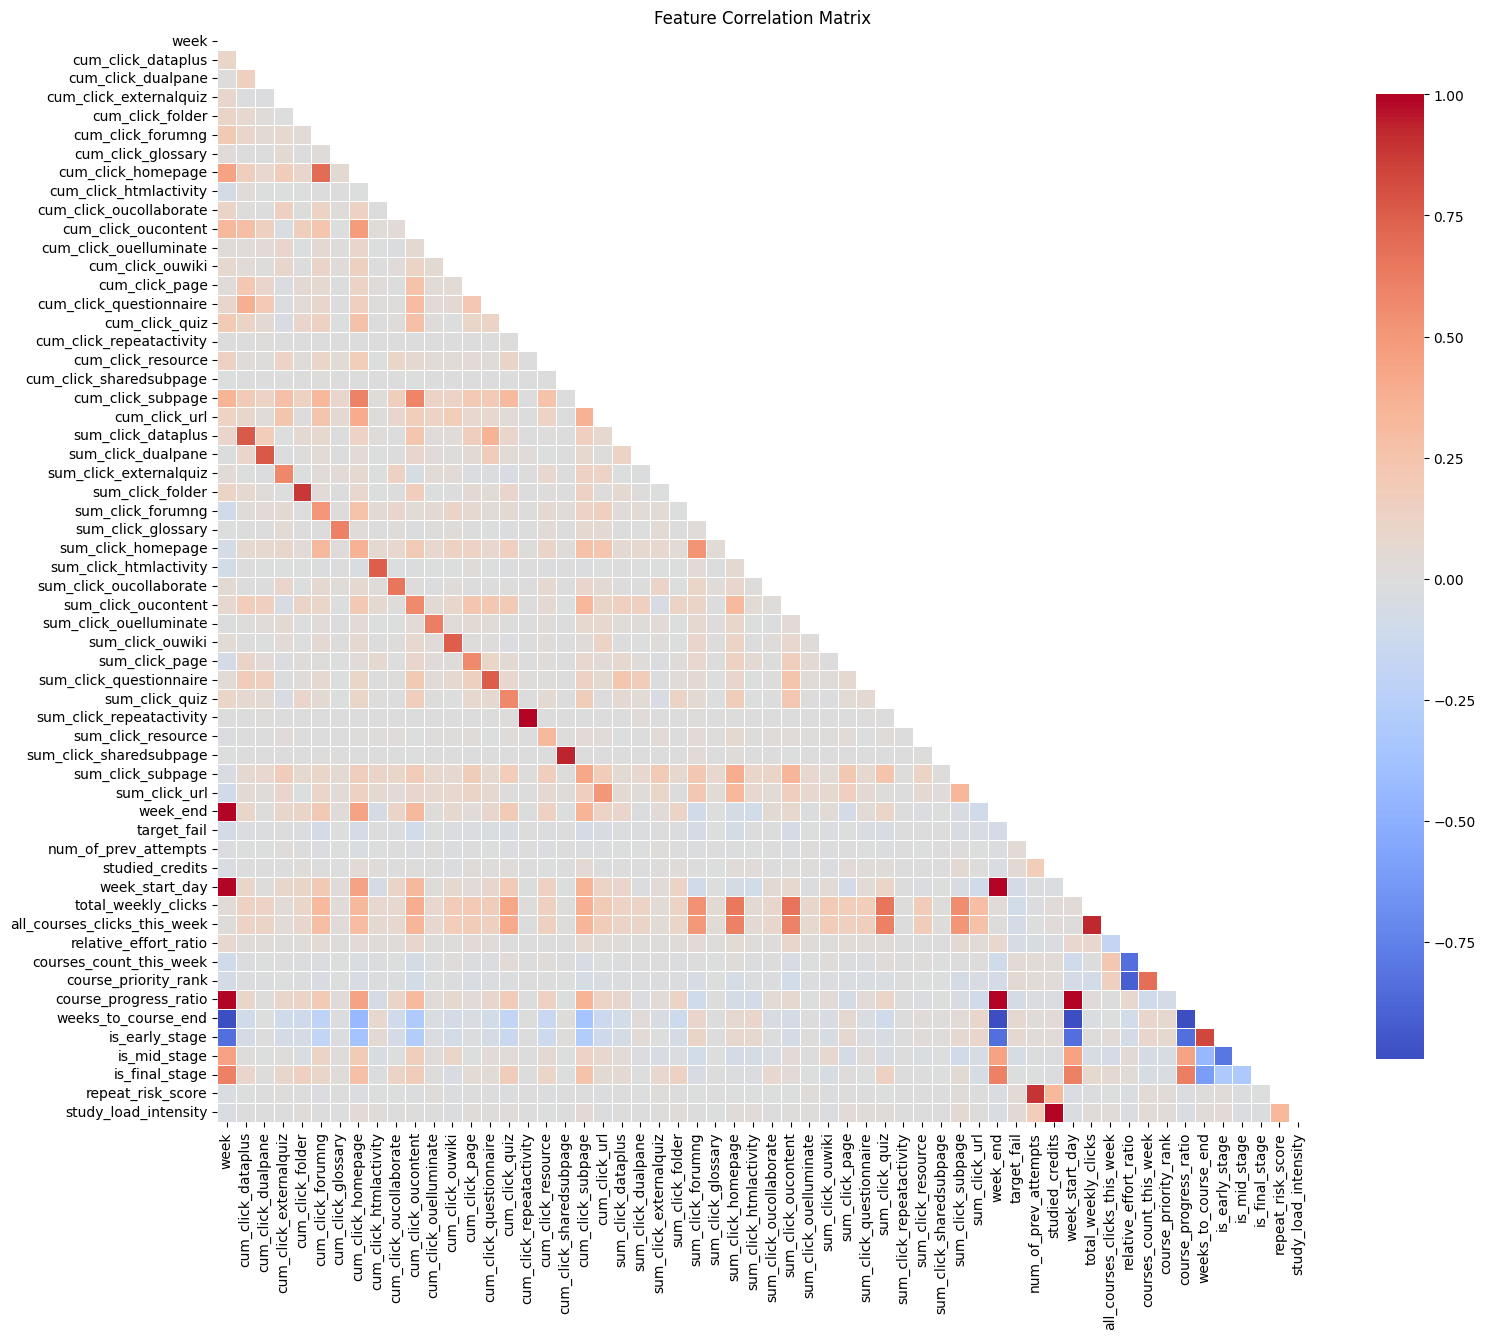


Highly Correlated Feature Pairs (|r| > 0.8):
                   Feature_1                     Feature_2  Correlation
13           studied_credits          study_load_intensity     1.000000
6   cum_click_repeatactivity      sum_click_repeatactivity     1.000000
8                   week_end                week_start_day     1.000000
0                       week                      week_end     1.000000
1                       week                week_start_day     1.000000
9                   week_end         course_progress_ratio     0.995428
14            week_start_day         course_progress_ratio     0.995428
2                       week         course_progress_ratio     0.995428
20     course_progress_ratio           weeks_to_course_end    -0.990692
3                       week           weeks_to_course_end    -0.984032
15            week_start_day           weeks_to_course_end    -0.984032
10                  week_end           weeks_to_course_end    -0.984032
7    cum_click_sha

In [7]:
## 7. Feature Correlation Analysis

print(f"\n=== CORRELATION ANALYSIS ===")

# Select numeric columns for correlation analysis
numeric_for_corr = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns and highly sparse columns
exclude_cols = ['id_student', 'code_presentation']
numeric_for_corr = [col for col in numeric_for_corr if col not in exclude_cols]

# Calculate correlation matrix
correlation_matrix = df[numeric_for_corr].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated features (> 0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.sort_values('Correlation', key=abs, ascending=False))
else:
    print("\nNo highly correlated feature pairs found (|r| > 0.8)")

# Correlation with target
target_corr = correlation_matrix['target_fail'].abs().sort_values(ascending=False)
print(f"\nTop 10 Features Most Correlated with Target:")
print(target_corr.head(10))


=== RISK FACTOR ANALYSIS ===

Low Weekly Clicks:
  Population with risk: 136,727 (24.3%)
  Failure rate with risk: 10.93%
  Failure rate without risk: 5.46%
  Risk ratio: 2.00x

Low Effort Ratio:
  Population with risk: 134,236 (23.8%)
  Failure rate with risk: 10.22%
  Failure rate without risk: 5.72%
  Risk ratio: 1.79x

Previous Attempts:
  Population with risk: 58,584 (10.4%)
  Failure rate with risk: 9.77%
  Failure rate without risk: 6.44%
  Risk ratio: 1.52x


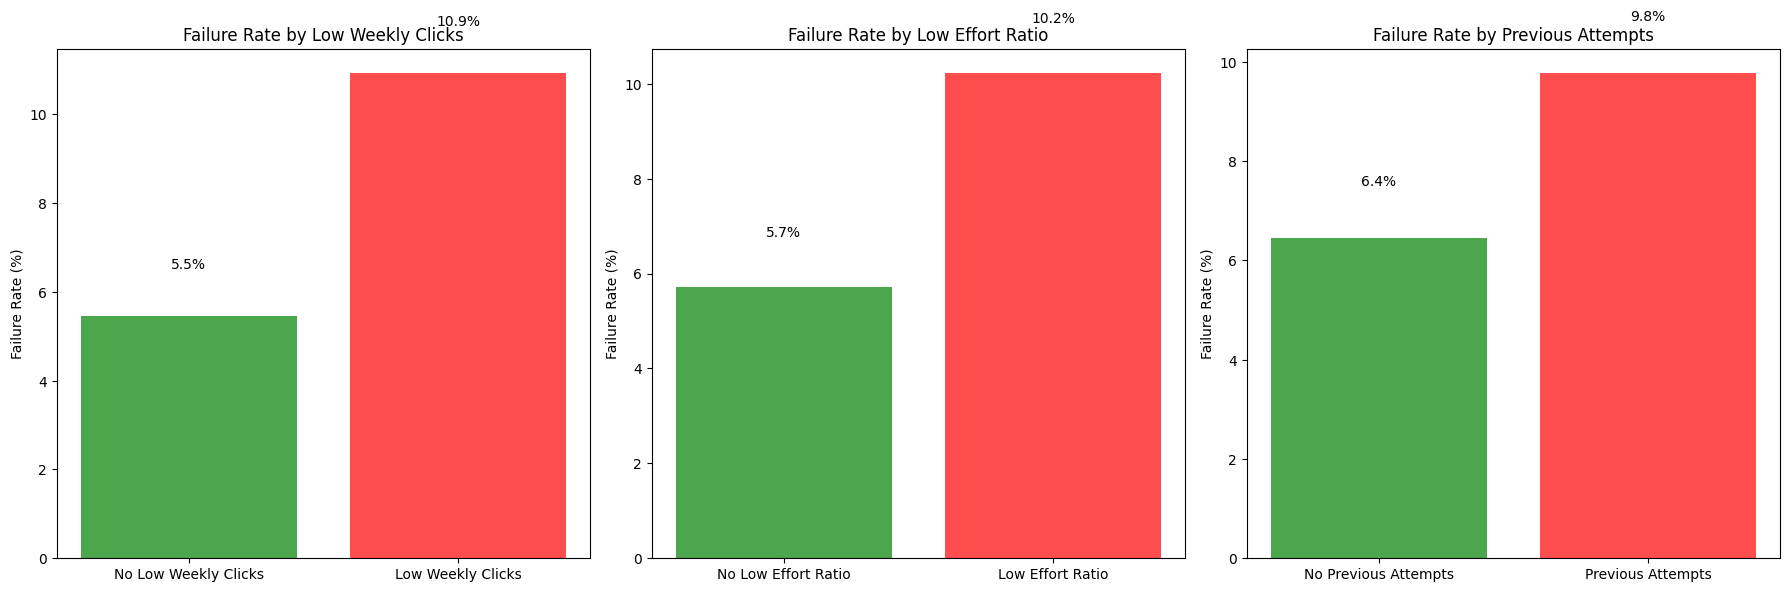

In [8]:
## 8. Advanced Insights and Risk Factors

### 8.1 Risk Factor Analysis

print(f"\n=== RISK FACTOR ANALYSIS ===")

# Create risk score based on key factors
risk_factors = []

# Low engagement risk
if 'total_weekly_clicks' in df.columns:
    low_engagement = df['total_weekly_clicks'] < df['total_weekly_clicks'].quantile(0.25)
    risk_factors.append(('Low Weekly Clicks', low_engagement))

# Low effort risk  
if 'relative_effort_ratio' in df.columns:
    low_effort = df['relative_effort_ratio'] < df['relative_effort_ratio'].quantile(0.25)
    risk_factors.append(('Low Effort Ratio', low_effort))

# High repeat attempts
if 'num_of_prev_attempts' in df.columns:
    high_repeats = df['num_of_prev_attempts'] > 0
    risk_factors.append(('Previous Attempts', high_repeats))

# Analysis for each risk factor
fig, axes = plt.subplots(1, len(risk_factors), figsize=(6*len(risk_factors), 6))
if len(risk_factors) == 1:
    axes = [axes]

for i, (risk_name, risk_condition) in enumerate(risk_factors):
    # Calculate failure rates for risk groups
    risk_failure_rate = df[risk_condition]['target_fail'].mean() * 100
    no_risk_failure_rate = df[~risk_condition]['target_fail'].mean() * 100
    
    # Bar plot
    categories = [f'No {risk_name}', risk_name]
    failure_rates = [no_risk_failure_rate, risk_failure_rate]
    
    bars = axes[i].bar(categories, failure_rates, color=['green', 'red'], alpha=0.7)
    axes[i].set_title(f'Failure Rate by {risk_name}')
    axes[i].set_ylabel('Failure Rate (%)')
    
    # Add percentage labels on bars
    for bar, rate in zip(bars, failure_rates):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    f'{rate:.1f}%', ha='center', va='bottom')
    
    print(f"\n{risk_name}:")
    print(f"  Population with risk: {risk_condition.sum():,} ({risk_condition.mean()*100:.1f}%)")
    print(f"  Failure rate with risk: {risk_failure_rate:.2f}%")
    print(f"  Failure rate without risk: {no_risk_failure_rate:.2f}%")
    print(f"  Risk ratio: {risk_failure_rate/no_risk_failure_rate:.2f}x")

plt.tight_layout()
plt.show()

In [9]:
## 9. Summary and Recommendations

print(f"\n" + "="*60)
print("EXECUTIVE SUMMARY & RECOMMENDATIONS")
print("="*60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"• Total samples: {df.shape[0]:,}")
print(f"• Features: {df.shape[1]:,}")
print(f"• Target failure rate: {df['target_fail'].mean()*100:.2f}%")

print(f"\n⚠️  KEY FINDINGS:")

# Class imbalance
if imbalance_ratio < 0.3:
    print(f"• IMBALANCED TARGET: Consider SMOTE, undersampling, or class weights")

# High correlations
if high_corr_pairs:
    print(f"• MULTICOLLINEARITY: {len(high_corr_pairs)} highly correlated pairs found")
    print("  → Consider feature selection or PCA")

# Top predictive features
top_predictors = target_corr.head(5).index.tolist()
top_predictors = [col for col in top_predictors if col != 'target_fail'][:3]
if top_predictors:
    print(f"• TOP PREDICTIVE FEATURES: {', '.join(top_predictors)}")

print(f"\n🎯 MODELING RECOMMENDATIONS:")
print("• Use stratified sampling to maintain class balance")
print("• Consider ensemble methods (Random Forest, XGBoost) for handling mixed data types")
print("• Implement cross-validation with temporal awareness if time-series")
print("• Monitor for overfitting due to many click-related features")

print(f"\n🔍 BUSINESS INSIGHTS:")
print("• Early intervention opportunities identified in temporal patterns")
print("• Demographics show varying risk levels - personalization potential")
print("• Engagement metrics are strong failure predictors")

print(f"\n✅ DATA QUALITY:")
print("• Dataset appears complete with minimal missing values")
print("• Rich feature set with both behavioral and demographic data")
print("• Suitable for supervised learning approaches")

print("\n" + "="*60)
print("EDA ANALYSIS COMPLETE")
print("="*60)


EXECUTIVE SUMMARY & RECOMMENDATIONS

📊 DATASET OVERVIEW:
• Total samples: 562,912
• Features: 69
• Target failure rate: 6.79%

⚠️  KEY FINDINGS:
• IMBALANCED TARGET: Consider SMOTE, undersampling, or class weights
• MULTICOLLINEARITY: 24 highly correlated pairs found
  → Consider feature selection or PCA
• TOP PREDICTIVE FEATURES: cum_click_oucontent, total_weekly_clicks, cum_click_homepage

🎯 MODELING RECOMMENDATIONS:
• Use stratified sampling to maintain class balance
• Consider ensemble methods (Random Forest, XGBoost) for handling mixed data types
• Implement cross-validation with temporal awareness if time-series
• Monitor for overfitting due to many click-related features

🔍 BUSINESS INSIGHTS:
• Early intervention opportunities identified in temporal patterns
• Demographics show varying risk levels - personalization potential
• Engagement metrics are strong failure predictors

✅ DATA QUALITY:
• Dataset appears complete with minimal missing values
• Rich feature set with both beh